# Using Amazon Comprehend Medical to build a digital assistant for doctors

Artificial Intelligence could potentially speed up the development of the process of new drug development, be a bridge to personalized medicine using the information of our genomes, and help address the problem of chronic shortage of doctors, especially in countries where health services are underdeveloped. However, significant challenges remain en-route to this utopian destination.

One is that the application of AI to the world's health problems isn't quite good enough yet. The other is the presence of the world's health data in the form of large unstructured medical text, which makes the process costly, time-consuming, and inefficient. WHO estimates that **< 20%** of the [world's medical data](https://www.bbc.com/news/business-48784205) is available in an ingestible format for AI algorithms to learn from.

Luckily, technology and healthcare are having a moment.

[**Amazon Comprehend Medical**](https://aws.amazon.com/comprehend/medical/) is an API-level service which is HIPAA eligible and uses machine learning to extract medical information with high accuracy. It eliminates the barriers to entry to access the biomedical knowledge stored in natural language text - from the research literature that entails biological processes and therapeutic mechanisms of action to the Electronic Medical Records that have the patients’ journeys through our healthcare systems documented.

It helps us comb through that information and study relationships like symptoms, diagnosis, medication, dosage while redacting the Protected Health Information (PHI). The following is an illustrative notebook that includes a step-by-step workflow for analyzing health data on the cloud.

These notebooks will be your go-to guide on using the AWS cloud programmatically and will also expose you to the relevant AWS services. All of this will be finally available as a reusable API for open data analytics workflow on the AWS cloud.

The suggested environment for running these notebooks is Amazon Sagemaker, a fully managed service that covers the entire machine learning pipeline - from labeling of the data to generating actionable insights.

## Why digital assistant for doctors? 

India is a country with roughly 450 million youth population. As the population grows and ages, more pressure is being put on medical professionals who're already struggling to cope with the increase in administration that comes with more patients wanting to be seen more often. There simply aren't enough doctors to go around.

Moreover, based on our public sector clients, we've learnt that there's [an increasing number of quack doctors](https://www.livehindustan.com/ncr/story-30-thousand-jholachap-doctors-are-playing-with-people-s-life-in-delhi-2423560.html) dispensing medical consultations to the rural/sub-urban populations of the country. A digital assistant, which records and processes their information to be then reviewed by a registered medical practitioner, will be immensely useful for validation. 

* An extended use case can be in telemedicine where people, with bare minimum access to medical personnel, can record their symptoms in the form of an audio clip which will be then be transcribed and the transcript of the same will be sent to the doctor in the form of a medical resume. This will enable the doctor to offer medical advice to a larger audience, amplifying his presence virtually. 


* A similar use case can be implemented in public hospitals where patients can record audio clips of their symptoms/history of their present illness in the form of an audio clip while waiting in a queue at the Out Patient Department (OPD) or in front of the doctor's cabin. The process will follow the above pipeline and generate a medical resume of the patient which will help the doctor cut through the chaff, prioritize and focus on objectives quicker. 

## The Solution Architecture

Once we've completed these workflow notebooks we build the following solution architecture, which is serverless and requires no procurement of software licenses. There's no need for managing any servers, virtual or otherwise, or operating systems. These services follow a pay-per-use billing policy. 




## Setup Notebook Environment

We'll be required to import the Python dependencies. We will begin by installing the following Python packages - `wordcloud`, `matplotlib` and `pypandoc`. We can do them using `! pip` as we will be running them outside the notebook environment. 

Following the installation of the packages, we'd be required to import the Python dependencies. We need `Boto3` - the Python SDK for AWS services, `Botocore` for managing exceptions. `Pandas` is the go-to library providing high-performance, easy-to-use data structures and data analysis tools for Python. `json` is a very handy built-in package called for encoding and decoding JSON data. The `IPython.display`, `Markdown` and `HTML` dependencies are required for well-formatted output from Notebook cells while `Audio` is for playing the Audio clip within the Sagemaker notebook. 

In [1]:
! pip3 install PyPandoc --user
! pip install wordcloud
! pip install matplotlib

  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/55/4f/59e0fa0914f3db52e87c0642c5fb986871dfbbf253026e639f
Successfully built PyPandoc
You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
autovizwidget 0.12.7 has requirement plotly<3.0,>=1.10.0, but you'll have plotly 3.10.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
autovizwidget 0.12.7 has requirement plotly<3.0,>=1.10.0, but you'll have plotly 3.10.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from botocore.vendored import requests
import json
import boto3
import pandas as pd
import pypandoc
import time
from IPython.display import display, Markdown, HTML, Audio

Before we start to access AWS services from an Amazon SageMaker notebook we need to ensure that the [SageMaker Execution IAM role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) associated with the notebook instance is allowed permissions to use the specific services like `Amazon S3, Amazon Comprehend Medical, DynamoDB and KMS`. 

We will setup various clients to call most of the APIs like Comprehend Medical, S3, DynamoDB and KMS.

In [3]:
comprehend = boto3.client(service_name='comprehendmedical')
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')
db = boto3.resource('dynamodb')
kms = boto3.client('kms')
transcribe = boto3.client('transcribe')

## Creating an S3 Bucket

Now we come to an important part of the workflow of creating a Python function. These functions are created all along this notebook and others in the series. Think of these functions as reusable APIs for applying all that you learn from AWS Open Data Analytics Notebooks into your own projects by simply importing these functions as a library.

Before we source the open dataset from the Registry, we need to define a destination for our data. We will store our open datasets within Amazon S3. S3 storage in turn is organized in **universally unique** `buckets`. These bucket names form special URLs of the format `s3://bucket-name` which access the contents of the buckets depending on security and access policies applied to the bucket and its contents. Buckets can further contain folders and files. Keys are combination of folder and file name path or just the file name in case it is within the bucket root.

Our first function create_bucket will do just that, it will create a bucket or return as-is if the bucket already exists for your account. If the bucket name is already used by someone else other than you, then this generates an exception caught by the message `Bucket <name> could not be created` as defined.

AWS services can be accessed using the SDK as we are using right now, using browser based console GUI, or using a Command Line Interface (CLI) over OS terminal or shell. Benefits of using the SDK are reusability of commands across different use cases, handling exceptions with custom actions, and focusing on just the functionality needed by the solution.

In [4]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'The bucket - "' + bucket + ' could not be created.'
    return 'The bucket - "' + bucket + '" has been created or already exists.'

In [5]:
create_bucket('comprehend-medical-sa-interns')

'The bucket - "comprehend-medical-sa-interns" has been created or already exists.'

## Exploring the contents of the Bucket 

Now that we have created the buckets, let's explore the contents of the bucket. The name of the Bucket is `comprehend-medical-sa-interns` and it has a folder named `medical_notes` which contains the raw clinical notes borrowed from `https://www.mtsamples.com/`. We can iterate through them using keys or the path names of file objects stored within the bucket. The function allows us to match and return only keys which contain the matching string. 

In [6]:
from decimal import *
s3_resource = boto3.resource('s3')

#replace the name of your corresponding dynamodb table between the single quotes below. You can find the name of the table in the outputs tab of the cloudforrmation stack.
ddb_table = 'medical-resume'

notes_dir = 's3://comprehend-medical-sa-interns'
mybucket = s3_resource.Bucket('comprehend-medical-sa-interns')

note_files1=[]
for key in mybucket.objects.all():
    if '.txt' in key.key:
        note_files1.append(key.key)

print(note_files1)


['medical_notes/file.txt', 'medical_notes/file1.txt', 'medical_notes/file10.txt', 'medical_notes/file11.txt', 'medical_notes/file12.txt', 'medical_notes/file2.txt', 'medical_notes/file20.txt', 'medical_notes/file21.txt', 'medical_notes/file3.txt', 'medical_notes/file4.txt', 'medical_notes/file5.txt', 'medical_notes/file6.txt']


Now that we've examined the Bucket, its folders and the contents in them, let's explore the content of a raw clinical note. Please remember to include `message = message.decode("utf-8")` for getting the display in a readable format. 

In [7]:
data = s3.get_object(Bucket='comprehend-medical-sa-interns', Key='medical_notes/file.txt')
message = data['Body'].read()

# You need to decode the message to get it in a readable format. 
message = message.decode("utf-8")

print(message)

Sample Type / Medical Specialty: Cardiovascular / Pulmonary
Sample Name: Abnormal Echocardiogram
Description: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency. The patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion.
(Medical Transcription Sample Report)
REASON FOR CONSULTATION: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency.

HISTORY OF PRESENT ILLNESS: The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusio

## Amazon Comprehend Medical in action

We'll now comb through the raw clinical notes and extract the various clinical entities and relationships from the notes using the Amazon Comprehend Medical API. These entities will then be inserted into a DynamoDB table. 

We apply a filter to restrict the collection of Personal Health Information (PHI) into the DynamoDB table and only collect relevant information from a clinical informatics purpose like symptoms, medications and diagnosis.

In [8]:
dynamoDBResource = boto3.resource('dynamodb', region_name = 'us-east-1')
table = dynamoDBResource.Table(ddb_table)
cm  = boto3.client(service_name='comprehendmedical', use_ssl=True, region_name = 'us-east-1')

# Setting the initial values of the counters and variables for the process
raw_rowid=1
rowid = 1
Trait_List = []
Attribute_List = []

# Defining variables for creating Wordclouds
text = ''
symptoms = ''
medication = ''
diagnosis = ''

# Creating empty lists for a dataframe
df_d = []  # Diagnosis
df_s = []  # Symptoms
df_m = []  # Medications

# Loop for each note file
for file in note_files1:
    print ('Processing '+file+ '...')
    
    # Open the file and read it into a variable
    print(file.split('/')[-1])
    print(file + ' has been processed.')
    s3_resource.Bucket('comprehend-medical-sa-interns').download_file(file, './Medical-Resume/'+ file.split('/')[-1])
    testtext = open('./Medical-Resume/'+ file.split('/')[-1]).read()
    
    # Call the detect_entities API to extract the entities
    testresult = cm.detect_entities(Text = testtext)
    
    # Create a list of entities
    testentities = testresult['Entities']
    
    # Inserting the JSON output into a dataframe.
    raw_rowid = raw_rowid + 1

    # Creating a loop to iterate through the individual entities
    for row in testentities:
        
        # Redacting PHI (Personal Health Information) from the extracted entites
        if row['Category'] != "PERSONAL_IDENTIFIABLE_INFORMATION":
            text += row['Text'] + ' '
            
            if len(row['Traits']) == 1 and row['Traits'][0]['Name'] == "SYMPTOM":
                symptoms += row['Text'] + ' '
                df_s.append(row['Text'])
                
            if row['Category'] == "MEDICATION":
                medication += row['Text'] + ' '
                df_m.append(row['Text'])
                
            if len(row['Traits']) == 1 and row['Traits'][0]['Name'] == "DIAGNOSIS":
                diagnosis += row['Text'] + ' '
                df_d.append(row['Text'])
                
            # Create a loop to iterate through each key in a row 
            for key in row:
                
                # Create a list of traits
                if key == 'Traits':
                    if len(row[key])>0:
                        Trait_List = []
                        for r in row[key]:
                            Trait_List.append(r['Name'])
                
                # Create a list of Attributes
                elif key == 'Attributes':
                    Attribute_List = []
                    for r in row[key]:
                        Attribute_List.append(r['Type']+':'+r['Text'])
            
            
            # Enter the row into DynamoDB
            table.put_item(
                Item={
                        'ROWID' : rowid,
                        'ID' : row['Id'],
                        'Text': row['Text'],
                        'Type' : row['Type'],
                        'Category' : row['Category'],
                        'Score' : Decimal(str(row['Score'])),
                        'Trait_List' : str(Trait_List),
                        'Attribute_List' : str(Attribute_List)
                        }
                    )

        rowid += 1

print ('\n Entities have been extracted and inserted into the dynamodb table.')

Processing medical_notes/file.txt...
file.txt
medical_notes/file.txt has been processed.
Processing medical_notes/file1.txt...
file1.txt
medical_notes/file1.txt has been processed.
Processing medical_notes/file10.txt...
file10.txt
medical_notes/file10.txt has been processed.
Processing medical_notes/file11.txt...
file11.txt
medical_notes/file11.txt has been processed.
Processing medical_notes/file12.txt...
file12.txt
medical_notes/file12.txt has been processed.
Processing medical_notes/file2.txt...
file2.txt
medical_notes/file2.txt has been processed.
Processing medical_notes/file20.txt...
file20.txt
medical_notes/file20.txt has been processed.
Processing medical_notes/file21.txt...
file21.txt
medical_notes/file21.txt has been processed.
Processing medical_notes/file3.txt...
file3.txt
medical_notes/file3.txt has been processed.
Processing medical_notes/file4.txt...
file4.txt
medical_notes/file4.txt has been processed.
Processing medical_notes/file5.txt...
file5.txt
medical_notes/file5.

## Visualizing extracted entities using a Wordcloud 

Now we've already processed 12 raw notes, we can expect certain medications/symptoms/diagnosis to repeat. We can use a wordcloud to simply understand the distribution of these labels. A Worldcloud would help us understand the frequency of these labels. 

We will be visualizing the clinical entities like symptoms, medication and diagnosis, except the personal information. 

In [9]:
# Creating visualizations

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

def medical_resume_wordcloud(text):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(width = 600, height = 300, background_color = 'black', max_words = len(text),
                          max_font_size = 30, relative_scaling = .5, colormap = 'Spectral').generate(text)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()

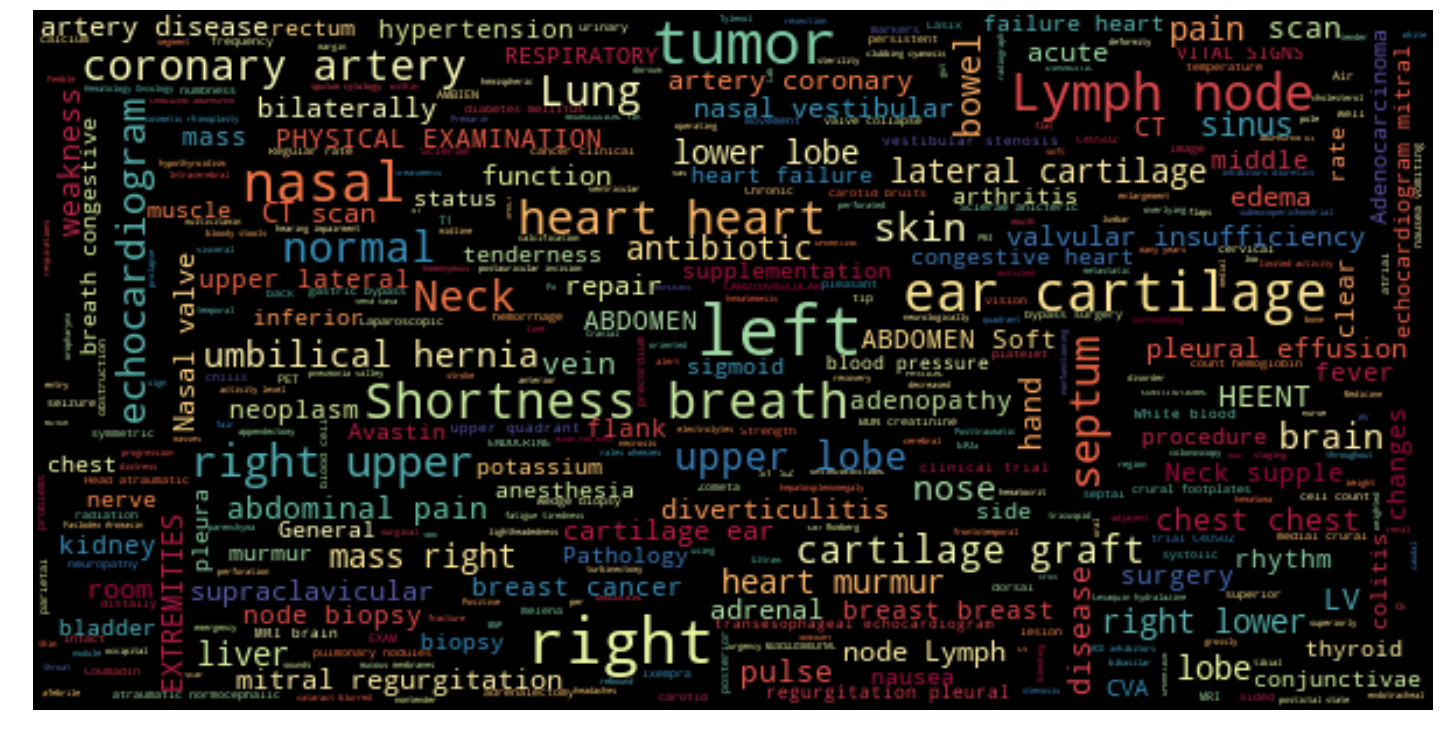

In [10]:
medical_resume_wordcloud(text)

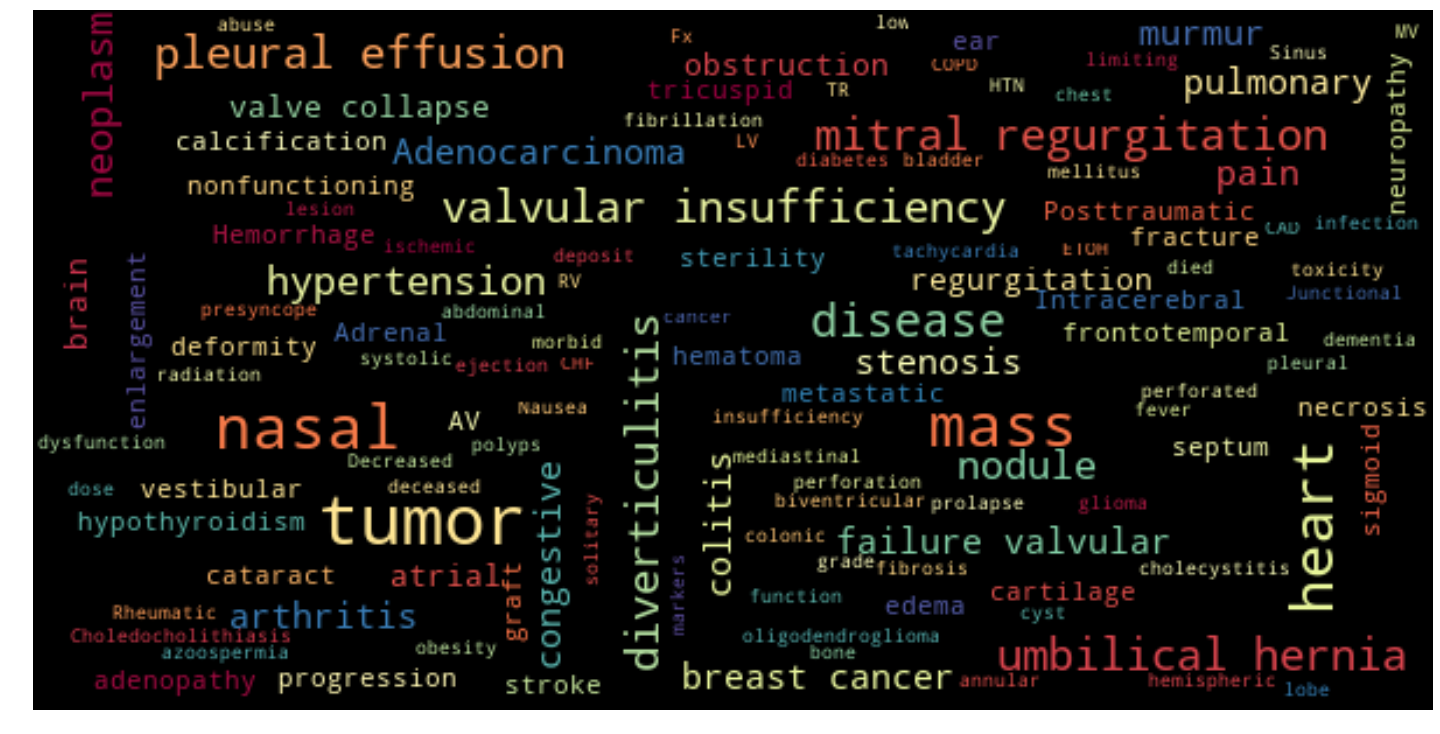

In [11]:
medical_resume_wordcloud(diagnosis)

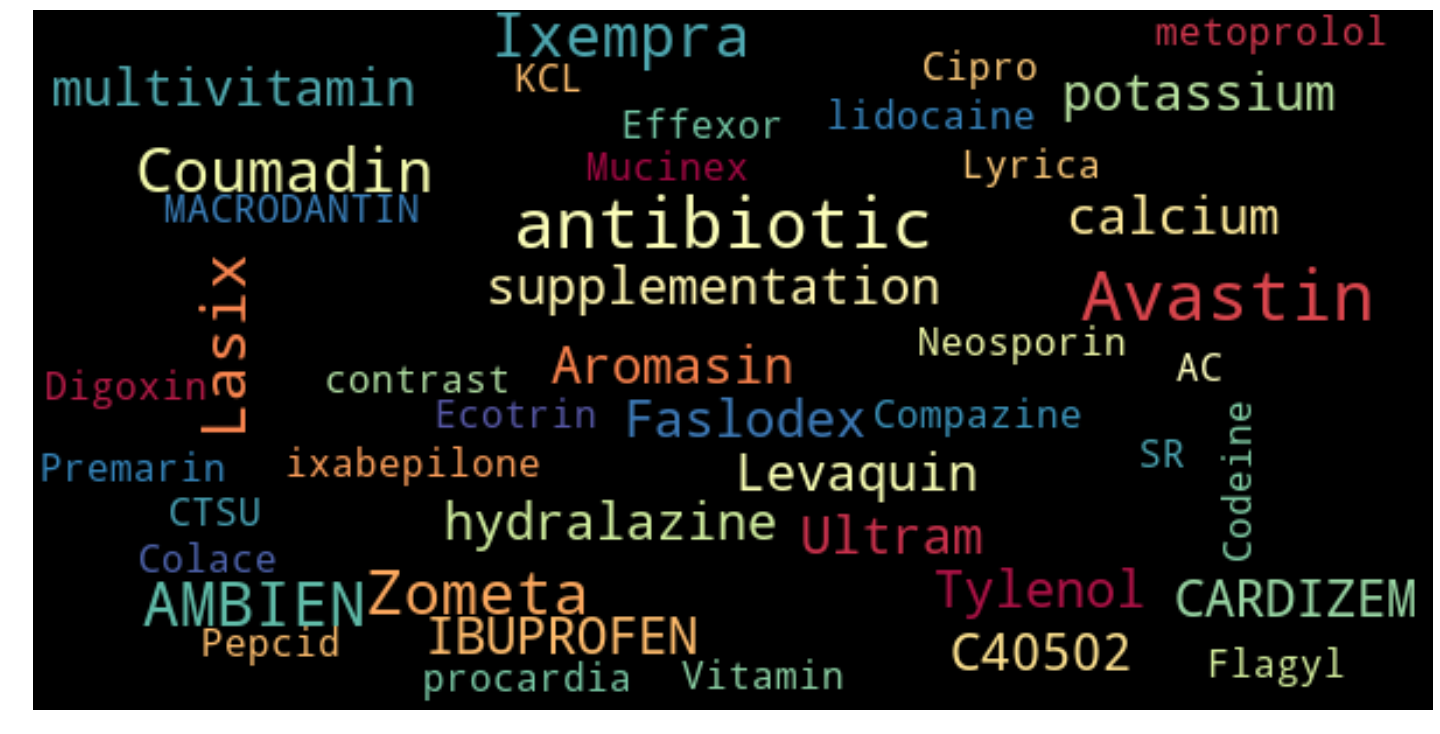

In [12]:
medical_resume_wordcloud(medication)

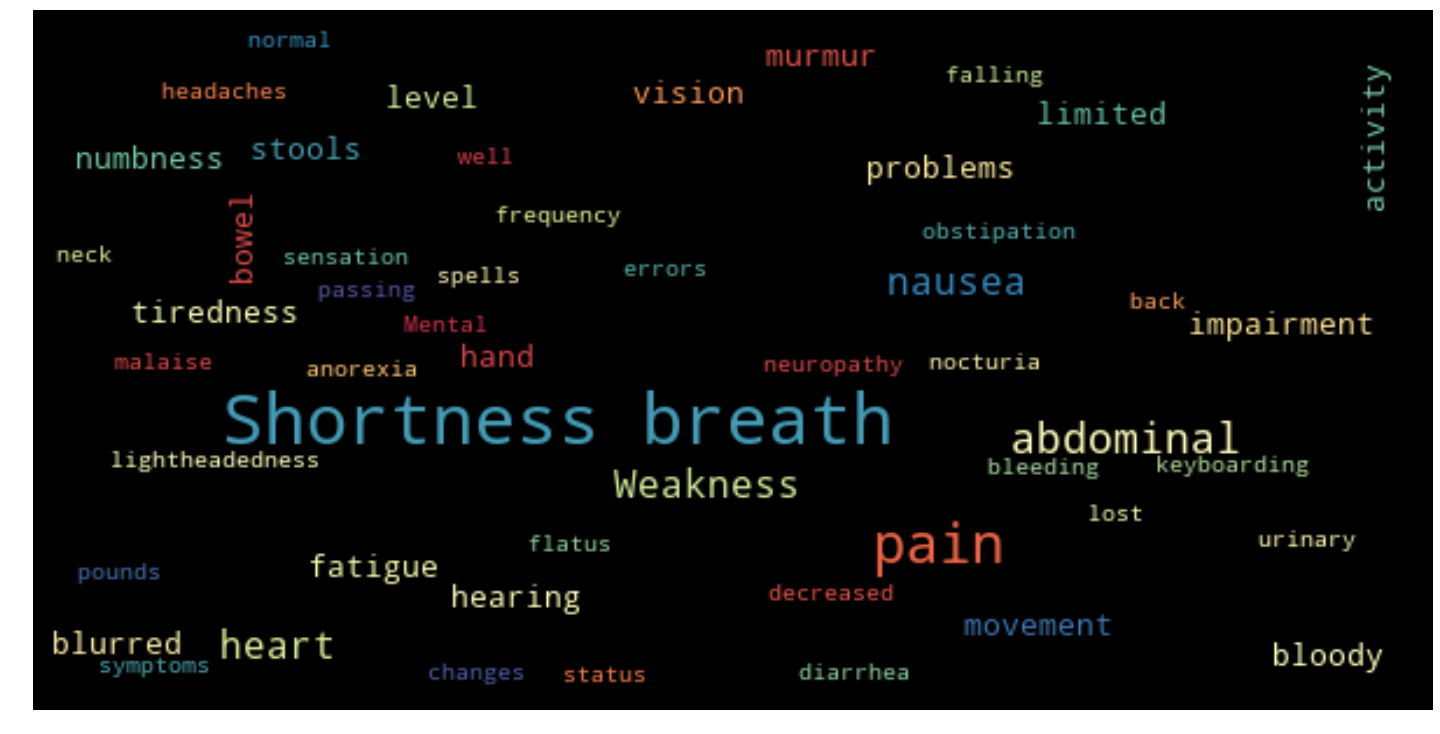

In [13]:
medical_resume_wordcloud(symptoms)

### Creating a Dataframe containing - diagnosis, symptoms and medications

Let's look at the diagnosis, medications and symptoms lists once before inserting them into a dataframe. 

In [14]:
print(df_s)   

['Shortness of breath', 'shortness of breath', 'Shortness of breath', 'abdominal pain', 'bloody stools', 'shortness of breath', 'limited activity level', 'shortness of breath', 'Weakness', 'fatigue', 'tiredness', 'blurred vision', 'hearing impairment', 'Shortness of breath', 'heart murmur', 'Shortness of breath', 'nausea', 'pain', 'Nausea', 'lost about 200 pounds', 'doing well', 'nausea', 'pain', 'malaise', 'normal bowel movement', 'Mental status changes', 'back problems', 'heart problems', 'neck pain', 'nocturia', 'urinary frequency', 'neuropathy', 'decreased sensation', 'errors when keyboarding', 'headaches', 'pain', 'diarrhea', 'bleeding', 'Shortness of breath', 'shortness of breath', 'Shortness of breath', 'abdominal pain', 'bloody stools', 'shortness of breath', 'limited activity level', 'shortness of breath', 'Weakness', 'fatigue', 'tiredness', 'blurred vision', 'hearing impairment', 'Shortness of breath', 'heart murmur', 'Shortness of breath', 'abdominal pain', 'Abdominal pain',

In [15]:
df1 = pd.DataFrame({'Diagnosis': pd.Series(df_d), 'Symptoms': pd.Series(df_s), 'Medications': pd.Series(df_m)})

## Exploring the dataset

As we have created the dataframe, let's preview and explore it. 

To preview the dataset we'll be using a new function to get an exciting summary of the dataset for previewing purpose. Please remember, you'd need to install `pandas-profiling` for the same. It's an easy wat to get an intuition of the structure of the data using just one line of code. 

While the `pandas` library provides many extremely useful functions for EDA. However, before being able to apply most of them, you generally have to start with more general functions, such as **df.describe( )/df.info( )**. Nevertheless, the functionality provided by such functions is limited and more often than not your initial EDA workflow is very similar for each new data set.

Instead of just giving you a single output, `pandas-profiling` enables its user to quickly generate a very broadly structured HTML file containing most of what you might need to know before diving into a more specific and individual data exploration. 

The feature is particularly useful when you have a dataset has a lot of variety in terms of type as well as the missing values. 

In [16]:
! pip3 install --user pandas-profiling

    100% |████████████████████████████████| 215kB 27.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 28.5MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 32.2MB/s ta 0:00:01


You are using pip version 19.0.2, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import pandas_profiling
df1.profile_report()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), se

## Generating a Medical Resume from the raw clinical notes

Let's move on with our journey of creating a Medical Reume now. We've already seen the power of Amazon Comprehend Medical. If we're able to extract relevant entities from an audio clip/text and present it in a more readable format to the doctors, it'll help save their time and also enable them to provide medical consultation to a larger audience. 

We will be importing `nltk` library at the moment so that we can perform a bit of processing on the output data - remove the repetitive symptoms/diagnosis from the notes of the output. This will make the resume focus on the clear priorities. 

The `porter_stemmer` function identifies a word and looks for its "stem" in the English dictionary and it classifies those words into one. This helps us treat the same word written in different styles and sort of normalizing the entire text for processing. 

In [18]:
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

Since we're generating the medical profile of the person in the form of a resume for the ease of access and readability, it's also possible for us to have the need for pushing it further for downstream population analytics. However, the Health Insurance Portability and Accountability Act (HIPAA) requires us to prevent revealing any information which can be used to trace back the individual. This information must only reside in the conversations between the doctors and the patients. 

The `cm.detect_phi` function lets us detect that information and then we have the option of redacting it or anonymizing/hashing it. This is a mighty important functionality which can be used to detect any form of Personal Information from documents and redact it. 

In [19]:
def extract_entities_from_message(message):
    return cm.detect_phi(Text=message)['Entities']

Before generating the resume, let's preview a clinical note in a `.txt` format which we will be passing as an input to generate the medical resume. 

In [20]:
resume_text_input = open('./Medical-Resume/'+ note_files1[0].split('/')[-1]).read()
print(resume_text_input)

Sample Type / Medical Specialty: Cardiovascular / Pulmonary
Sample Name: Abnormal Echocardiogram
Description: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency. The patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion.
(Medical Transcription Sample Report)
REASON FOR CONSULTATION: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency.

HISTORY OF PRESENT ILLNESS: The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusio

This note is well elaborated but contains a lot of information which when done away with will make the job of the doctor far more easier allowing him to spend more time on medically relevant information. We'll be using the `comprehend.detect_entities` function to extract clinically relevant information from the notes. 

We will then apply the `PorterStemmer()` function to normalize. 

In [21]:
entity_list = comprehend.detect_entities(Text = resume_text_input)['Entities']

In [22]:
porter_stemmer = PorterStemmer()

Now it's the time for creating a `DynamoDB` table. For simplicity purpose, we can treat it as a sample Electronic Health Record. 

In [23]:
# Creating EHR table in DynamoDB
def create_ehr_table(table_name):
    table = db.create_table(
    TableName=table_name,
    KeySchema=[
        {
            'AttributeName': 'ID',
            'KeyType': 'HASH'  #Partition key
        },
        {
            'AttributeName': 'DATE',
            'KeyType': 'RANGE'  #Sort key
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'ID',
            'AttributeType': 'N'
        },
        {
            'AttributeName': 'DATE',
            'AttributeType': 'S'
        },

    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 10,
        'WriteCapacityUnits': 10
    }
)

In [24]:
ehr_table = 'Electronic-Health-Records'
try:
    create_ehr_table(ehr_table)
    print('Table "{}" created successfully.'.format(ehr_table))
except:
    print('Table "{}" already exists.'.format(ehr_table))

Table "Electronic-Health-Records" already exists.


In [25]:
entity_list = ''

Now we have created a blank `entity list` and will be creating a Python class which will contain the attributes of the resume. We need to initialize a few things in the class like name, age, gender and address. The class also consists of a function which builds the resume. The function requires us to pass a couple of parameters - the ID of the patient and the input which will be used to generate the resume. 

The class also contains the function which writes the information into the EHR table we had earlier created in DynamoDB.

In [26]:
import time
class Resume:
    
    # Attributes of the resume. 
 
    name='Not Found'
    age = 'Not Found'
    gender = 'Not Found'
    dob = 'Not Found'
    address = 'Not Found'
    chief_medical_complaint = 'Not Found'
    current_date = ''
    symptoms = []
    allergies = []
    vital_signs = {}
    medications = []
    entity_list = []
    resume_text_input = ''
    htmlcode = '<font color="#b30000"><H1 align="center">Patient Information</H1></font>'
    
    def __init__(self,ID, raw_resume_text):
        
        self.ID = ID
        self.resume_text_input = raw_resume_text
        date = time.localtime()
        self.current_date = time.strftime("%Y-%m-%d", date)
        self.entity_list = comprehend.detect_entities(Text = self.resume_text_input)['Entities']
        
        # Initailizing name
        for entity in self.entity_list:
            if entity['Type'] =='Name':
                self.name = entity['Text']
                break
        
        # Initailizing age
        for entity in self.entity_list:
            if entity['Type'] =='AGE':
                age = entity['Text']
                break
        
        # Initailizing gender
        if ' female ' in resume_text_input.lower():
            self.gender = 'Female'
        elif ' male ' in resume_text_input.lower():
            self.gender = 'Male'
        
        for entity in self.entity_list:
            if entity['Type']=='DATE':
                S = resume_text_input[max(entity['BeginOffset']-10,0):entity['EndOffset']+1]
                if S.find('DOB')!=-1 or S.find('D.O.B.')!=-1 or S.find('Birth')!=-1:
                    self.dob = entity['Text']
        
        
        # Initailizing address
        address = ''
        for entity in self.entity_list:
            if entity['Type']=='ADDRESS':
                address += entity['Text']+', '
        if address !='':
             self.address = address[:-2]
        
        
        # Initailizing symptoms
        SymptomList = []
        StemSymList = []
        for entity in self.entity_list:
            if len(entity['Traits']) == 1 and entity['Traits'][0]['Name'] == 'SYMPTOM':
                symptom = entity['Text']
                stemmed_symptom = porter_stemmer.stem(symptom)
                if stemmed_symptom not in StemSymList :                                  
                    SymptomList.append(symptom.capitalize())
                    StemSymList.append(stemmed_symptom)           
        if len(SymptomList)!=0:
            self.chief_medical_complaint = SymptomList[0]
        self.symptoms = SymptomList
        
        
        # Initailizing allergies
        allergies = []
        for entity in self.entity_list:
            if ((entity['Type'] == 'BRAND_NAME' or entity['Type'] == 'GENERIC_NAME') and \
                len(entity['Traits'])!=0 and entity['Traits'][0]['Name']=='NEGATION'):
                allergies.append(entity['Text'])
        self.allergies = allergies        
                
        # Initailizing medications
        medications = []
        for entity in self.entity_list:
            medication = {'Generic_name':'NF','Strength':'NF','Dosage':'NF','Form':'NF','Route_or_mode':'NF','Frequency':'NF'} 
            if (entity['Type'] == 'GENERIC_NAME' or entity['Type'] == 'BRAND_NAME') and 'Attributes' in entity:
                medication['Generic_name'] = entity['Text']
                for attribute in entity['Attributes']:
                    medication[attribute['Type'].capitalize()] = attribute['Text']
                
                medications.append(medication)
        self.medications = medications
        
        # Initailizing vital signs
        self.vital_signs = {'Found':[],'Negated':[]}
        for entity in self.entity_list:
            if entity['Category']=='MEDICAL_CONDITION' and len(entity['Text'].split(' '))>1:
                if len(entity['Traits'])== 1 and entity['Traits'][0]['Name']== 'SIGN':
                    self.vital_signs['Found'].append(entity['Text'])
    
                if ((len(entity['Traits'])== 2 and entity['Traits'][0]['Name']== 'SIGN' and \
                    entity['Traits'][1]['Name']== 'NEGATION')):
                    self.vital_signs['Negated'].append(entity['Text'])
        
        
        # Initailizing medical_tests
        TEST = []
        self.medical_tests =  []       
        for entity in self.entity_list:
            if entity['Type'] == 'TEST_NAME' and 'Attributes' in entity and \
                len(entity['Attributes'])>0 and entity['Text'].lower() not in TEST :
                medical_test = {'Test_name':'','Test_value':''}
                TEST.append(entity['Text'].lower())
                medical_test['Test_name'] = entity['Text'].capitalize()
                for test in entity['Attributes']:
                    medical_test['Test_value'] += test['Text'] + ' '
                self.medical_tests.append(medical_test)
         
                
                
                
    # Generating the Medical Resume   
    def make_resume(self):
        
        self.htmlcode += '<b>ID : </b>' + str(self.ID)+'<br><br>' 
        
        self.htmlcode += '<b>Name : </b>' + self.name+'<br><br>'   
        
        self.htmlcode += '<b>Age : </b>' + str(self.age)+'<br><br>'
        
        self.htmlcode += '<b>Gender : </b>' + self.gender + '<br><br>'
        
        self.htmlcode += '<b>DOB : </b>' + self.dob + '<br><br>'
        
        self.htmlcode += '<b>Address : </b>' + self.address + '<br><br>'
        
        self.htmlcode += '<b>Time of Visit : </b>' + self.current_date + '<br><br>'
        
        self.htmlcode += '<b>Chief Medical Complaint : </b>' + self.chief_medical_complaint +'<br><br>'
        
        self.htmlcode += '<b>Symptoms : </b><br><br><table><tr>'
        for i in range(len(self.symptoms)):
            self.htmlcode += '<td><ul><li>'+self.symptoms[i] + '</li></ul></td>'
            if (i+1)%4 == 0 or i == len(self.symptoms)-1:
                self.htmlcode += '</tr>'
                if i != len(self.symptoms)-1:
                    self.htmlcode += '<tr>'
        self.htmlcode += '</table>' + (' <br>'*3) + '<b>Allergies : </b>'
        
        self.htmlcode += str(self.allergies)[1:-1].replace("'",'') + '<br><br>'
        
        self.htmlcode += '<b>Vital Signs : </b><br><ul>'
        self.htmlcode += '<li>Found : ' + str(self.vital_signs['Found'])[1:-1].replace("'",'') + '</li><br>'
        self.htmlcode += '<li>Negated : ' + str(self.vital_signs['Negated'])[1:-1].replace("'",'') + '</li></ul><br>'
        
        
        attributes = {'Generic_name','Strength','Dosage','Form','Route_or_mode','Frequency'}
        self.htmlcode += '<b>Medications : </b><br><table><tr>'
        for attribute in attributes:
            self.htmlcode += '<th><b>'+attribute+'</b></th>'
        self.htmlcode += '</tr>'
        for medication in self.medications:
            self.htmlcode += '<tr>'
            for key in medication:
                self.htmlcode += '<td>' + medication[key] + '</td>'
            self.htmlcode += '</tr>'
        self.htmlcode += '</table><br><br>'
        
 
        self.htmlcode += '<b>Medical Tests : </b><br><ul>'
        for test in self.medical_tests:
            self.htmlcode += '<li>' + test['Test_name'] + ' : ' + test['Test_value'] + '</li>' 
        self.htmlcode += '</ul>'
        return self.htmlcode
        
    def display_resume(self):
        resume = self.make_resume()
        display(HTML(resume))
        
    def save_to_ehr(self,table_name,bucket_name):
        self.htmlcode = self.make_resume()
        html_key = f'HTML/{self.ID}/{self.current_date}.html'
        doc_key = f'DOCX/{self.ID}/{self.current_date}.docx'
        
        # Saving html file to disk
        html_file = open('resume.html',"w").write(self.htmlcode)
        pypandoc.convert_file('resume.html', 'docx', outputfile="resume.docx")
        
        # saving html and docx file to s3 bucket
        s3.put_object(Bucket = bucket_name, Key = html_key, Body = open('resume.html',"rb"))
        s3.put_object(Bucket = bucket_name, Key = doc_key, Body = open('resume.docx',"rb"))
        
        table = db.Table(table_name)
        response = table.put_item(
            Item = {
                'ID' : self.ID,
                'DATE' : self.current_date,
                'NAME' : self.name,
                'AGE' : self.age,
                'GENDER' : self.gender,
                'DOB' : self.dob,
                'ADDRESS' : self.address,
                'CHIEF_MEDICAL_COMPLAINT' : self.chief_medical_complaint,
                'SYMPTOMS' : self.symptoms,
                'ALLERGIES' : self.allergies,
                'VITAL_SIGNS' : self.vital_signs,
                'MEDICATIONS' : self.medications,
                'MEDICAL_NOTES' : self.medical_tests,
                'RESUME_LINK' : f's3://{bucket_name}/{html_key}'
        }
        )


## The `make_resume` function

The function takes in two parameters - one which is the ID of the patient and the other is the text you would want to provide as an input to the function for generating the resume. 

In [27]:
resume_text_input = '''Sample Type / Medical Specialty: General Medicine
Sample Name: Annual Health Maintenance Exam
Description: Comprehensive annual health maintenance examination, dyslipidemia, tinnitus in left ear, and hemorrhoids.
(Medical Transcription Sample Report)
HISTORY OF PRESENT ILLNESS: This 59-year-old white male is seen for comprehensive annual health maintenance examination on 06/25/19, although this patient is in excellent overall health. Medical problems include chronic tinnitus in the left ear with moderate hearing loss for many years without any recent change, dyslipidemia well controlled with niacin, history of hemorrhoids with occasional external bleeding, although no problems in the last 6 months, and also history of concha bullosa of the left nostril, followed by ENT associated with slight septal deviation. There are no other medical problems. He has no symptoms at this time and remains in excellent health.

PAST MEDICAL HISTORY: Otherwise noncontributory. There is no operation, serious illness or injury other than as noted above.

ALLERGIES: There are no known allergies.

FAMILY HISTORY: Father died of an MI at age 67 with COPD and was a heavy smoker. His mother is 88, living and well, status post lung cancer resection. Two brothers, living and well. One sister died at age 20 months of pneumonia.

SOCIAL HISTORY: The patient is married. Wife is living and well. He jogs or does Cross Country track 5 times a week, and weight training twice weekly. No smoking or significant alcohol intake. He is a physician in allergy/immunology.

REVIEW OF SYSTEMS: Otherwise noncontributory. He has no gastrointestinal, cardiopulmonary, genitourinary or musculoskeletal symptomatology. No symptoms other than as described above.

PHYSICAL EXAMINATION:
GENERAL: He appears alert, oriented, and in no acute distress with excellent cognitive function. VITAL SIGNS: His height is 6 feet 2 inches, weight is 181.2, blood pressure is 126/80 in the right arm, 122/78 in the left arm, pulse rate is 68 and regular, and respirations are 16. SKIN: Warm and dry. There is no pallor, cyanosis or icterus. HEENT: Tympanic membranes benign. The pharynx is benign. Nasal mucosa is intact. Pupils are round, regular, and equal, reacting equally to light and accommodation. EOM intact. Fundi reveal flat discs with clear margins. Normal vasculature. No hemorrhages, exudates or microaneurysms. No thyroid enlargement. There is no lymphadenopathy. LUNGS: Clear to percussion and auscultation. Normal sinus rhythm. No premature beat, murmur, S3 or S4. Heart sounds are of good quality and intensity. The carotids, femorals, dorsalis pedis, and posterior tibial pulsations are brisk, equal, and active bilaterally. ABDOMEN: Benign without guarding, rigidity, tenderness, mass or organomegaly. NEUROLOGIC: Grossly intact. EXTREMITIES: Normal. GU: Genitalia normal. There are no inguinal hernias. There are mild hemorrhoids in the anal canal. The prostate is small, if any normal to mildly enlarged with discrete margins, symmetrical without significant palpable abnormality. There is no rectal mass. The stool is Hemoccult negative.

IMPRESSION:
1. Comprehensive annual health maintenance examination.
2. Dyslipidemia.
3. Tinnitus, left ear.
4. Hemorrhoids.

PLAN: At this time, continue niacin 1000 mg in the morning, 500 mg at noon, and 1000 mg in the evening; aspirin 81 mg daily; multivitamins; vitamin E 400 units daily; and vitamin C 500 mg daily. Consider adding lycopene, selenium, and flaxseed to his regimen. All appropriate labs will be obtained today. Followup fasting lipid profile and ALT in 6 months. 
'''

In [28]:
my_resume = Resume(1,resume_text_input)
my_resume.display_resume()

We will now be pushing the components of the **Medical Resume** into the corresponding sections of the EHR table using the `save_to_ehr` function. 

In [29]:
my_resume.save_to_ehr(ehr_table,'comprehend-medical-sa-interns')

For another example, let us take an input which is slightly more detailed and elaborate to populate certain fields of the resume better. 

In [30]:
resume_text_input = '''Sample Type / Medical Specialty: Cardiovascular / Pulmonary
Sample Name: Abnormal Echocardiogram
Description: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency. The patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion.
(Medical Transcription Sample Report)
REASON FOR CONSULTATION: Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, and valvular insufficiency.

HISTORY OF PRESENT ILLNESS: The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion. This consultation is for further evaluation in this regard. As per the patient, she is an 86-year-old female, has limited activity level. She has been having shortness of breath for many years. She also was told that she has a heart murmur, which was not followed through on a regular basis.

CORONARY RISK FACTORS: History of hypertension, no history of diabetes mellitus, nonsmoker, cholesterol status unclear, no prior history of coronary artery disease, and family history noncontributory.

FAMILY HISTORY: Nonsignificant.

PAST SURGICAL HISTORY: No major surgery.

MEDICATIONS: Presently on Lasix, potassium supplementation, Levaquin, hydralazine 10 mg b.i.d., antibiotic treatments, and thyroid supplementation.

ALLERGIES: AMBIEN, CARDIZEM, AND IBUPROFEN.

PERSONAL HISTORY: She is a nonsmoker. Does not consume alcohol. No history of recreational drug use.

PAST MEDICAL HISTORY: Basically GI pathology with diverticulitis, colitis, hypothyroidism, arthritis, questionable hypertension, no prior history of coronary artery disease, and heart murmur.

REVIEW OF SYSTEMS
CONSTITUTIONAL: Weakness, fatigue, and tiredness.
HEENT: History of cataract, blurred vision, and hearing impairment.
CARDIOVASCULAR: Shortness of breath and heart murmur. No coronary artery disease.
RESPIRATORY: Shortness of breath. No pneumonia or valley fever.
GASTROINTESTINAL: No nausea, vomiting, hematemesis, or melena.
UROLOGICAL: No frequency or urgency.
MUSCULOSKELETAL: Arthritis and severe muscle weakness.
SKIN: Nonsignificant.
NEUROLOGICAL: No TIA or CVA. No seizure disorder.
ENDOCRINE/HEMATOLOGICAL: As above.

PHYSICAL EXAMINATION
VITAL SIGNS: Pulse of 84, blood pressure of 168/74, afebrile, and respiratory rate 16 per minute.
HEENT/NECK: Head is atraumatic and normocephalic. Neck veins flat. No significant carotid bruits appreciated.
LUNGS: Air entry bilaterally fair. No obvious rales or wheezes.
HEART: PMI displaced. S1, S2 with systolic murmur at the precordium, grade 2/6.
ABDOMEN: Soft and nontender.
EXTREMITIES: Chronic skin changes. Feeble pulses distally. No clubbing or cyanosis.

DIAGNOSTIC DATA: EKG: Normal sinus rhythm. No acute ST-T changes.

Echocardiogram report was reviewed.

LABORATORY DATA: H&H 13 and 39. BUN and creatinine within normal limits. Potassium within normal limits. BNP 9290.

IMPRESSION:
1. The patient admitted for gastrointestinal pathology, under working treatment.
2. History of prior heart murmur with echocardiogram findings as above. Basically revealed normal left ventricular function with left atrial enlargement, large pleural effusion, and severe mitral regurgitation and tricuspid regurgitation.

RECOMMENDATIONS:
1. From cardiac standpoint, conservative treatment. Possibility of a transesophageal echocardiogram to assess valvular insufficiency adequately well discussed extensively.
2. After extensive discussion, given her age 86, limited activity level, and no intention of undergoing any treatment in this regard from a surgical standpoint, the patient does not wish to proceed with a transesophageal echocardiogram.
3. Based on the above findings, we will treat her medically with ACE inhibitors and diuretics and see how she fares. She has a normal LV function.'''

In [31]:
start = time.time()
my_resume2 = Resume(2,resume_text_input)
my_resume2.display_resume()
my_resume2.save_to_ehr(ehr_table,'comprehend-medical-sa-interns')
end = time.time()

print("The time taken to generate this resume: {} seconds".format(end-start))

The time taken to generate this resume: 2.6562340259552 seconds


Now we can observe that the resume is very elaborate and has a lot of fields with entries against them. We have also saved these to the EHR table which we had created in **DynamoDB**. 

# Generating resumes from audio files

Now that we have processed text inputs and have turned them into a resume, it's time for us to take a look at handling audio clips. 

The workflow would look something like this -   
    1) Add an audio clip to the S3 bucket.   
    2) Process the audio clip through **Amazon Transcribe** to get its transcript.   
    3) Pass on the transcript further to generate the **Medical Resume**. 
    
We have a sample audio clip added to the S3 bucket. We can play it within this Sagemaker Notebook using the `Audio` function.  

In [32]:
bucket = 'comprehend-medical-sa-interns'
key = 'Sample.mp3'
audio_obj = s3.get_object(Bucket=bucket, Key=key)
audio = audio_obj["Body"].read()
Audio(audio)

Now we will be creating a job in the Amazon Transcription (which is our Speech Recognition tool). This job will help us get the transcript of the audio file we just played. 

In [33]:
# Funtion to create a transcription job
def create_trancription(job_name, bucket, key, output_bucket):
    input_url = f's3://{bucket}/{key}'
    transcribe.start_transcription_job(
    TranscriptionJobName=job_name,
    Media={'MediaFileUri': input_url},
    MediaFormat=key.split('.')[-1],
    OutputBucketName=output_bucket,
    LanguageCode='en-US'
    )
    i = 1
    while True:
        status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
        if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
            break
        b = "Converting" + "." * i
        i = (i+1)
        print (b, end="\r")
        if i==5:
            i=1
            print ("Converting"+ ' ' * 4, end= "\r")
        #print(i)
        time.sleep(1)
    print (' '* len(b), end="\r")
    print(status['TranscriptionJob']['TranscriptionJobStatus'])

In [34]:
job_name = 'Doctor-Patient-Conversation-Transcription'
bucket = 'comprehend-medical-sa-interns'
key = 'Sample.mp3'
output_bucket = 'comprehend-medical-sa-interns-transcription-output'
create_trancription(job_name, bucket, key, output_bucket)

COMPLETED     


In [35]:
# Fuction to read transcibe output
def read_transcribe_output(bucket,key):
    file = s3_resource.Object(bucket, key)
    json_text = file.get()['Body'].read()
    return json.loads(json_text)['results']['transcripts'][0]['transcript'] 

Now is the time for us to pass on the text input from the audio into Comprehend Medical to generate a medical resume of the same. 

In [36]:
medical_text = read_transcribe_output(output_bucket, job_name + '.json')

In [37]:
my_resume = Resume(3,medical_text)
my_resume.display_resume()

In [38]:
# Deleting the transcription job which we created earlier. 
transcribe.delete_transcription_job(TranscriptionJobName=job_name)

{'ResponseMetadata': {'RequestId': 'ea5b4c36-fc2b-44d4-82f4-1dc253a02fdf',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 16 Jul 2019 12:12:38 GMT',
   'x-amzn-requestid': 'ea5b4c36-fc2b-44d4-82f4-1dc253a02fdf',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# Appendix: 

### This section contains all the user-defined functions which have been used time and again in the entire notebook. We can think of them as reusable APIs. 

Following is a list of functions used for miscellaneous purposes on the SDK and using several AWS services. 

In [39]:
# This is the function to create a bucket
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'The bucket - "' + bucket + ' could not be created.'
    return 'The bucket - "' + bucket + '" has been created or already exists.'

# Defining the function which creates the Wordcloud
def medical_resume_wordcloud(text):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(width = 600, height = 300, background_color = 'black', max_words = len(text),
                          max_font_size = 30, relative_scaling = .5, colormap = 'Spectral').generate(text)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()
    
# This function is for extracting Personal Health Information (PHI) from the input passed into it
def extract_entities_from_message(message):
    return cm.detect_phi(Text=message)['Entities']

# This function creates an Electronic Health Record (EHR) in a DynamoDB table
def create_ehr_table(table_name):
    table = db.create_table(
    TableName=table_name,
    KeySchema=[
        {
            'AttributeName': 'ID',
            'KeyType': 'HASH'  #Partition key
        },
        {
            'AttributeName': 'DATE',
            'KeyType': 'RANGE'  #Sort key
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'ID',
            'AttributeType': 'N'
        },
        {
            'AttributeName': 'DATE',
            'AttributeType': 'S'
        },

    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 10,
        'WriteCapacityUnits': 10
    }
)
    
# This function creates a transcription job
def create_trancription(job_name, bucket, key, output_bucket):
    input_url = f's3://{bucket}/{key}'
    transcribe.start_transcription_job(
    TranscriptionJobName=job_name,
    Media={'MediaFileUri': input_url},
    MediaFormat=key.split('.')[-1],
    OutputBucketName=output_bucket,
    LanguageCode='en-US'
    )
    i = 1
    while True:
        status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
        if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
            break
        b = "Converting" + "." * i
        i = (i+1)
        print (b, end="\r")
        if i==5:
            i=1
            print ("Converting"+ ' ' * 4, end= "\r")
        #print(i)
        time.sleep(1)
    print (' '* len(b), end="\r")
    print(status['TranscriptionJob']['TranscriptionJobStatus'])
    
# This is the function to read the output of Amazon Transcript
def read_transcribe_output(bucket,key):
    file = s3_resource.Object(bucket, key)
    json_text = file.get()['Body'].read()
    return json.loads(json_text)['results']['transcripts'][0]['transcript'] 

The following class is responsible for creating the resume. 

In [40]:
# This function is how to create the Medical Resume

import time
class Resume:
    
    # Attributes of the resume. 
 
    name='Not Found'
    age = 'Not Found'
    gender = 'Not Found'
    dob = 'Not Found'
    address = 'Not Found'
    chief_medical_complaint = 'Not Found'
    current_date = ''
    symptoms = []
    allergies = []
    vital_signs = {}
    medications = []
    entity_list = []
    resume_text_input = ''
    htmlcode = '<font color="#b30000"><H1 align="center">Patient Information</H1></font>'
    
    def __init__(self,ID, raw_resume_text):
        
        self.ID = ID
        self.resume_text_input = raw_resume_text
        date = time.localtime()
        self.current_date = time.strftime("%Y-%m-%d", date)
        self.entity_list = comprehend.detect_entities(Text = self.resume_text_input)['Entities']
        
        # Initailizing name
        for entity in self.entity_list:
            if entity['Type'] =='Name':
                self.name = entity['Text']
                break
        
        # Initailizing age
        for entity in self.entity_list:
            if entity['Type'] =='AGE':
                age = entity['Text']
                break
        
        # Initailizing gender
        if ' female ' in resume_text_input.lower():
            self.gender = 'Female'
        elif ' male ' in resume_text_input.lower():
            self.gender = 'Male'
        
        for entity in self.entity_list:
            if entity['Type']=='DATE':
                S = resume_text_input[max(entity['BeginOffset']-10,0):entity['EndOffset']+1]
                if S.find('DOB')!=-1 or S.find('D.O.B.')!=-1 or S.find('Birth')!=-1:
                    self.dob = entity['Text']
        
        
        # Initailizing address
        address = ''
        for entity in self.entity_list:
            if entity['Type']=='ADDRESS':
                address += entity['Text']+', '
        if address !='':
             self.address = address[:-2]
        
        
        # Initailizing symptoms
        SymptomList = []
        StemSymList = []
        for entity in self.entity_list:
            if len(entity['Traits']) == 1 and entity['Traits'][0]['Name'] == 'SYMPTOM':
                symptom = entity['Text']
                stemmed_symptom = porter_stemmer.stem(symptom)
                if stemmed_symptom not in StemSymList :                                  
                    SymptomList.append(symptom.capitalize())
                    StemSymList.append(stemmed_symptom)           
        if len(SymptomList)!=0:
            self.chief_medical_complaint = SymptomList[0]
        self.symptoms = SymptomList
        
        
        # Initailizing allergies
        allergies = []
        for entity in self.entity_list:
            if ((entity['Type'] == 'BRAND_NAME' or entity['Type'] == 'GENERIC_NAME') and \
                len(entity['Traits'])!=0 and entity['Traits'][0]['Name']=='NEGATION'):
                allergies.append(entity['Text'])
        self.allergies = allergies        
                
        # Initailizing medications
        medications = []
        for entity in self.entity_list:
            medication = {'Generic_name':'NF','Strength':'NF','Dosage':'NF','Form':'NF','Route_or_mode':'NF','Frequency':'NF'} 
            if (entity['Type'] == 'GENERIC_NAME' or entity['Type'] == 'BRAND_NAME') and 'Attributes' in entity:
                medication['Generic_name'] = entity['Text']
                for attribute in entity['Attributes']:
                    medication[attribute['Type'].capitalize()] = attribute['Text']
                
                medications.append(medication)
        self.medications = medications
        
        # Initailizing vital signs
        self.vital_signs = {'Found':[],'Negated':[]}
        for entity in self.entity_list:
            if entity['Category']=='MEDICAL_CONDITION' and len(entity['Text'].split(' '))>1:
                if len(entity['Traits'])== 1 and entity['Traits'][0]['Name']== 'SIGN':
                    self.vital_signs['Found'].append(entity['Text'])
    
                if ((len(entity['Traits'])== 2 and entity['Traits'][0]['Name']== 'SIGN' and \
                    entity['Traits'][1]['Name']== 'NEGATION')):
                    self.vital_signs['Negated'].append(entity['Text'])
        
        
        # Initailizing medical_tests
        TEST = []
        self.medical_tests =  []       
        for entity in self.entity_list:
            if entity['Type'] == 'TEST_NAME' and 'Attributes' in entity and \
                len(entity['Attributes'])>0 and entity['Text'].lower() not in TEST :
                medical_test = {'Test_name':'','Test_value':''}
                TEST.append(entity['Text'].lower())
                medical_test['Test_name'] = entity['Text'].capitalize()
                for test in entity['Attributes']:
                    medical_test['Test_value'] += test['Text'] + ' '
                self.medical_tests.append(medical_test)
         
                
                
                
    # Generating the Medical Resume   
    def make_resume(self):
        
        self.htmlcode += '<b>ID : </b>' + str(self.ID)+'<br><br>' 
        
        self.htmlcode += '<b>Name : </b>' + self.name+'<br><br>'   
        
        self.htmlcode += '<b>Age : </b>' + str(self.age)+'<br><br>'
        
        self.htmlcode += '<b>Gender : </b>' + self.gender + '<br><br>'
        
        self.htmlcode += '<b>DOB : </b>' + self.dob + '<br><br>'
        
        self.htmlcode += '<b>Address : </b>' + self.address + '<br><br>'
        
        self.htmlcode += '<b>Time of Visit : </b>' + self.current_date + '<br><br>'
        
        self.htmlcode += '<b>Chief Medical Complaint : </b>' + self.chief_medical_complaint +'<br><br>'
        
        self.htmlcode += '<b>Symptoms : </b><br><br><table><tr>'
        for i in range(len(self.symptoms)):
            self.htmlcode += '<td><ul><li>'+self.symptoms[i] + '</li></ul></td>'
            if (i+1)%4 == 0 or i == len(self.symptoms)-1:
                self.htmlcode += '</tr>'
                if i != len(self.symptoms)-1:
                    self.htmlcode += '<tr>'
        self.htmlcode += '</table>' + (' <br>'*3) + '<b>Allergies : </b>'
        
        self.htmlcode += str(self.allergies)[1:-1].replace("'",'') + '<br><br>'
        
        self.htmlcode += '<b>Vital Signs : </b><br><ul>'
        self.htmlcode += '<li>Found : ' + str(self.vital_signs['Found'])[1:-1].replace("'",'') + '</li><br>'
        self.htmlcode += '<li>Negated : ' + str(self.vital_signs['Negated'])[1:-1].replace("'",'') + '</li></ul><br>'
        
        
        attributes = {'Generic_name','Strength','Dosage','Form','Route_or_mode','Frequency'}
        self.htmlcode += '<b>Medications : </b><br><table><tr>'
        for attribute in attributes:
            self.htmlcode += '<th><b>'+attribute+'</b></th>'
        self.htmlcode += '</tr>'
        for medication in self.medications:
            self.htmlcode += '<tr>'
            for key in medication:
                self.htmlcode += '<td>' + medication[key] + '</td>'
            self.htmlcode += '</tr>'
        self.htmlcode += '</table><br><br>'
        
 
        self.htmlcode += '<b>Medical Tests : </b><br><ul>'
        for test in self.medical_tests:
            self.htmlcode += '<li>' + test['Test_name'] + ' : ' + test['Test_value'] + '</li>' 
        self.htmlcode += '</ul>'
        return self.htmlcode
        
    def display_resume(self):
        resume = self.make_resume()
        display(HTML(resume))
        
    def save_to_ehr(self,table_name,bucket_name):
        self.htmlcode = self.make_resume()
        html_key = f'HTML/{self.ID}/{self.current_date}.html'
        doc_key = f'DOCX/{self.ID}/{self.current_date}.docx'
        
        # Saving html file to disk
        html_file = open('resume.html',"w").write(self.htmlcode)
        pypandoc.convert_file('resume.html', 'docx', outputfile="resume.docx")
        
        # saving html and docx file to s3 bucket
        s3.put_object(Bucket = bucket_name, Key = html_key, Body = open('resume.html',"rb"))
        s3.put_object(Bucket = bucket_name, Key = doc_key, Body = open('resume.docx',"rb"))
        
        table = db.Table(table_name)
        response = table.put_item(
            Item = {
                'ID' : self.ID,
                'DATE' : self.current_date,
                'NAME' : self.name,
                'AGE' : self.age,
                'GENDER' : self.gender,
                'DOB' : self.dob,
                'ADDRESS' : self.address,
                'CHIEF_MEDICAL_COMPLAINT' : self.chief_medical_complaint,
                'SYMPTOMS' : self.symptoms,
                'ALLERGIES' : self.allergies,
                'VITAL_SIGNS' : self.vital_signs,
                'MEDICATIONS' : self.medications,
                'MEDICAL_NOTES' : self.medical_tests,
                'RESUME_LINK' : f's3://{bucket_name}/{html_key}'
        }
        )